In [ ]:
!pip install keras==3.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00


In [ ]:
import keras
from keras import layers

import math
import numpy as np
import pandas as pd
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from functools import partial
import tensorflow
import optuna

In [ ]:

# Colunas do conjunto de dados Bank Marketing
CSV_HEADER = ["gender", "SeniorCitizen", "Partner",
    "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges", "Churn"
]

# Carrega o conjunto de dados do CSV
blastchar_data = df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
blastchar_data.drop("customerID", axis = 1, inplace = True)
# Exibe as primeiras linhas do DataFrame
blastchar_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
from sklearn.model_selection import train_test_split

# Separar features (X) e rótulos (y)
X = blastchar_data[CSV_HEADER[:-1]]  # Todas as colunas, exceto a última (rótulo 'y')
y = blastchar_data['Churn']  # A última coluna (rótulo 'y')

# Dividir o conjunto de dados em treino (65%), teste (20%) e validação (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.43, random_state=42)

# Criar DataFrames para treino, teste e validação
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [ ]:
train_data_file = "train_data.csv"
val_data_file = "val_data.csv"
test_data_file = "test_data.csv"

df_train.to_csv(train_data_file, index=False, header=False)
df_val.to_csv(val_data_file, index=False, header=False)
df_test.to_csv(test_data_file, index=False, header=False)

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(df_train["gender"].unique())),
    "Partner": sorted(list(df_train["Partner"].unique())),
    "Dependents": sorted(list(df_train["Dependents"].unique())),  # Assuming housing is binary
    "PhoneService": sorted(list(df_train["PhoneService"].unique())),  # Assuming loan is binary
    "MultipleLines": sorted(list(df_train["MultipleLines"].unique())),  # Assuming contact is binary
    "InternetService": sorted(list(df_train["InternetService"].unique())),
    "OnlineSecurity": sorted(list(df_train["OnlineSecurity"].unique())),
    "OnlineBackup": sorted(list(df_train["OnlineBackup"].unique())),
    "DeviceProtection": sorted(list(df_train["DeviceProtection"].unique())),
    "TechSupport": sorted(list(df_train["TechSupport"].unique())),
    "StreamingTV": sorted(list(df_train["StreamingTV"].unique())),
    "StreamingMovies": sorted(list(df_train["StreamingMovies"].unique())),
    "Contract": sorted(list(df_train["Contract"].unique())),
    "PaperlessBilling": sorted(list(df_train["PaperlessBilling"].unique())),
    "PaymentMethod": sorted(list(df_train["PaymentMethod"].unique())),
}
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "Churn"
# A list of the labels of the target features.
TARGET_LABELS = ["No", "Yes"]


#Run experiment

In [ ]:
#Best Hyperparameters: {'LEARNING_RATE': 0.00025308525929178786, 'WEIGHT_DECAY': 0.08754310714002143, 'DROPOUT_RATE': 0.5}
LEARNING_RATE = 0.00025308525929178786
WEIGHT_DECAY = 0.08754310714002143
DROPOUT_RATE = 0.5
BATCH_SIZE = 256
NUM_EPOCHS = 300

NUM_TRANSFORMER_BLOCKS = 6  # Number of transformer blocks.
NUM_HEADS = 8  # Number of attention heads.
EMBEDDING_DIMS = 32  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    4,
    2,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [ ]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    return features, target_index,


lookup_dict = {}

for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, nor expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 0.
    lookup = layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup


def encode_categorical(batch_x, batch_y):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = lookup_dict[feature_name](batch_x[feature_name])

    return batch_x, batch_y


def get_dataset_from_csv(csv_file_path, batch_size=256, shuffle=False):
    dataset = (
        tf_data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size=batch_size,
            column_names=CSV_HEADER,
            column_defaults=COLUMN_DEFAULTS,
            label_name=TARGET_FEATURE_NAME,
            num_epochs=1,
            header=False,
            na_value="?",
            shuffle=shuffle,
        )
        .map(prepare_example, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
        # .repeat(count=250)
    )
    return dataset.cache()




/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="binary_accuracy")],
    )
    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(val_data_file, batch_size)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    callbacks = [
    keras.callbacks.EarlyStopping(
        patience=15, monitor='val_loss', mode = 'min')
    ]
    print("Start training the model...")
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data = validation_dataset,
        callbacks=callbacks
    )
    print("Model training finished")
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"test accuracy: {round(accuracy * 100, 2)}%")

    # Obter rótulos verdadeiros do conjunto de dados de validação
    y_val = []
    for batch in test_dataset:
        y_val.append(batch[1].numpy())
    y_val = np.concatenate(y_val, axis=0)
    # Obter previsões do modelo no conjunto de dados de validação
    y_pred = model.predict(test_dataset)
    # # Aplicar um limiar de 0,5 às previsões
    # y_pred_binary = (y_pred >= 0.5).astype(int)
    # Calcular a AUC
    auc = roc_auc_score(y_val, y_pred)
    print(f"AUC after training: {auc:.4f}")


    y_test = []
    for batch in test_dataset:
      y_test.append(batch[1].numpy())
    y_test = np.concatenate(y_test, axis=0)

    y_pred_test = model.predict(test_dataset)
    y_pred_test_binary = (y_pred_test >= 0.5).astype(int)
    for i in range(len(y_test)):
      print(f"True Label: {y_test[i]}, Predicted Label: {y_pred_test_binary[i]}")
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


    return history


In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
    return inputs

#MLP

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer()),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [ ]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.

            # Convert the string input values into integer indices.

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = keras.ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [ ]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
# keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Total model weights: 3297353


In [ ]:
# history = run_experiment(
#     model=baseline_model,
#     train_data_file=train_data_file,
#     test_data_file=test_data_file,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
#     weight_decay=WEIGHT_DECAY,
#     batch_size=BATCH_SIZE,
# )

#TabTransformer

In [ ]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = keras.ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = keras.ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
# keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Total model weights: 3034841


Start training the model...
Epoch 1/300
     18/Unknown 94s 2s/step - binary_accuracy: 0.5838 - loss: 1.0230  

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - binary_accuracy: 0.5852 - loss: 1.0190 - val_binary_accuracy: 0.6234 - val_loss: 1.1094
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.6567 - loss: 0.8096 - val_binary_accuracy: 0.6935 - val_loss: 0.6706
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.6791 - loss: 0.7378 - val_binary_accuracy: 0.7356 - val_loss: 0.6705
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.7001 - loss: 0.7112 - val_binary_accuracy: 0.7839 - val_loss: 0.5383
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.7118 - loss: 0.6747 - val_binary_accuracy: 0.6912 - val_loss: 0.7844
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7139 - loss: 0.6639 - val_binary_accuracy: 0.7310 - val_loss: 0.6101
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7195 - loss: 0.6482 - val_binary_accuracy: 0.7300 - val_loss: 0.6090
Epoch 8/300
18/18 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 1, Predicted Label: [1]
True Label: 0, Predicted Label: [0]
True Label: 1, Predicted Label: [1]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 1, Predicted Label: [1]
True Label: 0, Predicted Label: [1]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 1, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [0]
True Label: 0, Predicted Label: [1]
True Label: 0, Predicted Label: [0]
True Label: 1, Predicted Lab

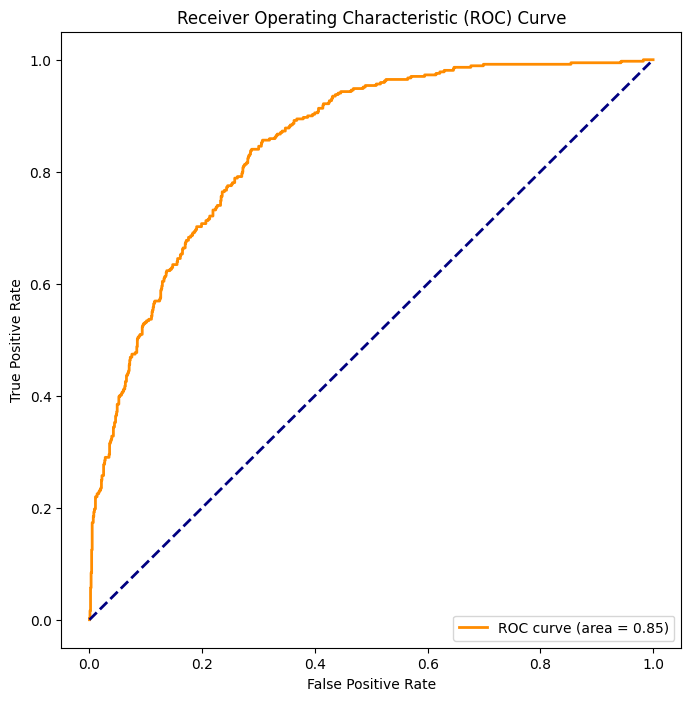

In [ ]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

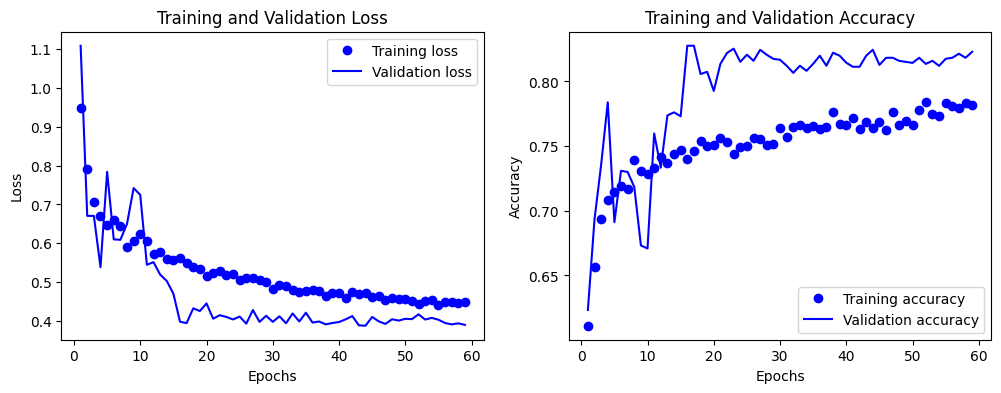

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Obter métricas de treinamento
    loss = history.history['loss']
    accuracy = history.history['binary_accuracy']  # Substitua 'binary_accuracy' pelo nome da sua métrica de accuracy se necessário

    # Obter métricas de validação (se disponíveis)
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_binary_accuracy']  # Substitua 'val_binary_accuracy' pelo nome da sua métrica de accuracy de validação se necessário

    # Número de épocas
    epochs = range(1, len(loss) + 1)

    # Plotar loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotar accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    if 'val_binary_accuracy' in history.history:
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Exemplo de uso:
# Supondo que 'history' seja o objeto retornado ao treinar o modelo usando model.fit()
plot_training_history(history)